In [ ]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

In [ ]:
# Load data
mat = scipy.io.loadmat('ants/sampleEEGdata.mat')
EEG = mat['EEG'][0, 0]
EEG

In [ ]:
# Initialize parameters
nTrials = 4
wavetime = np.arange(-1, 1 + 1/EEG['srate'][0][0], 1/EEG['srate'][0][0])
n_conv = len(wavetime) + EEG['pnts'][0][0] - 1
wavelet = (np.exp(2 * 1j * np.pi * 10 * wavetime) * 
           np.exp(-wavetime**2 / (2 * (5 / (2 * np.pi * 10))**2)) / 10)
waveletfft = np.fft.fft(wavelet, n_conv)
data10hz = np.zeros((nTrials, EEG['pnts'][0][0]))
wavetime
n_conv
wavelet
waveletfft
data10hz

In [ ]:
# Constants for ERP generation
ERP_FREQUENCY = 6  # Frequency in Hz for ERP signal
ERP_PHASE_OFFSET = -np.pi  # Phase offset for ERP signal
NOISE_STD_ERP = 1/6  # Standard deviation of ERP noise
ERP_AMPLITUDE = 0.15  # Amplitude of the ERP

# Constants for stimulus potential
STIM_FREQUENCY = 10  # Frequency in Hz for stimulus potential
STIM_PHASE_OFFSET = -np.pi  # Phase offset for stimulus potential varies with trial
STIM_AMPLITUDE = 1/5  # Amplitude of the stimulus noise

# Constants for wavelet convolution
WAVELET_NORMALIZATION = np.sqrt(5 / (2 * np.pi * STIM_FREQUENCY))
POWER_SCALING_FACTOR = 2  # Factor for power scaling post-convolution

# Time vector from EEG data
time_vector = EEG['times'][0] / 1000  # Converted to seconds from ms

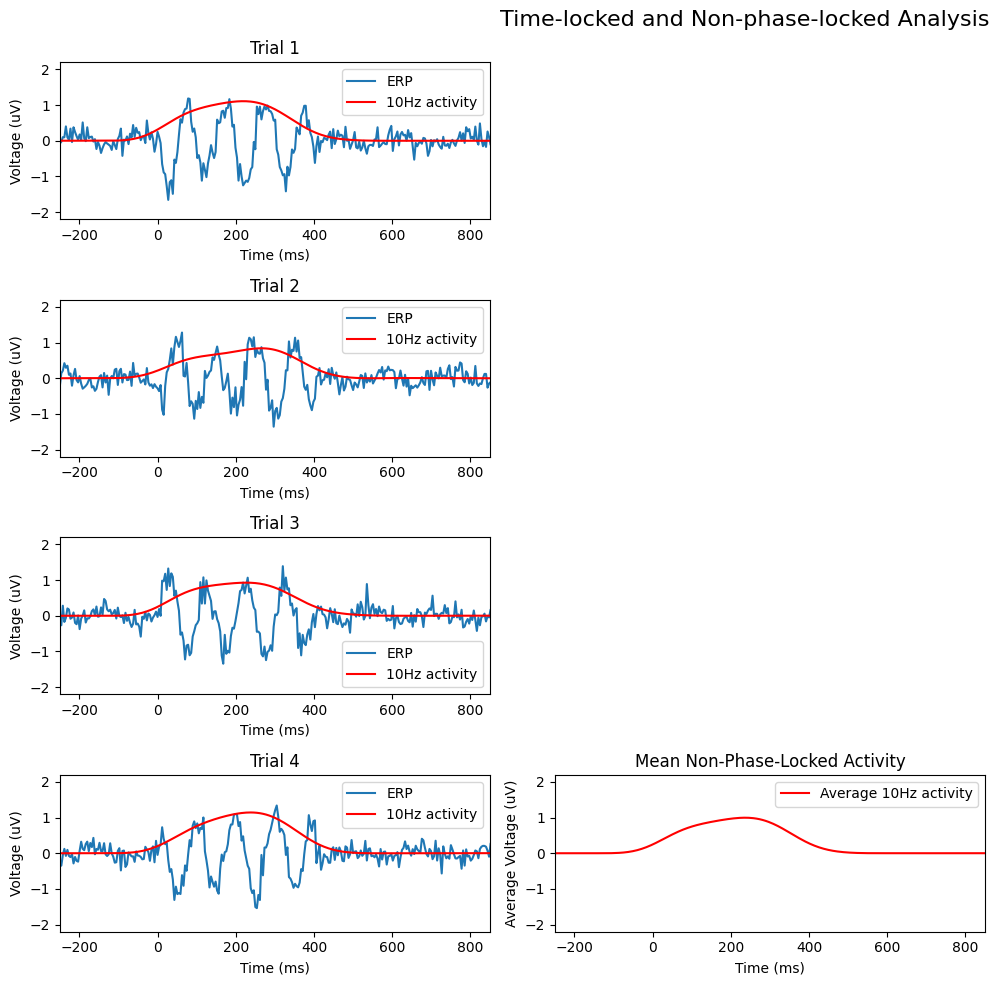

In [55]:
# Time-locked and non-phase-locked
plt.figure(figsize=(15, 10))
plt.suptitle('Time-locked and Non-phase-locked Analysis', fontsize=16)  # Main title
for triali in range(nTrials):
    # Create single trial Event-Related Potential (ERP) with sinusoidal base and noise
    base_erp_signal = ERP_AMPLITUDE * np.sin(2 * np.pi * ERP_FREQUENCY * time_vector + 
                                            2 * np.pi * triali / nTrials + ERP_PHASE_OFFSET)
    erp_noise = np.random.randn(EEG['pnts'][0][0]) * NOISE_STD_ERP
    data = base_erp_signal + erp_noise
    
    # Add non-phase-locked stimulus potential to the ERP signal within the specified time window
    stim_time_vector = time_vector[259:360]  # Subset of time for stimulus potential
    stim_potential = np.sin(2 * np.pi * STIM_FREQUENCY * stim_time_vector + 
                        2 * np.pi * triali / nTrials + STIM_PHASE_OFFSET)
    stim_noise = np.random.randn(101) * STIM_AMPLITUDE
    data[259:360] += stim_potential + stim_noise

    # Perform convolution with the 10Hz wavelet to analyze frequency-specific activity
    conv_res = fftconvolve(data, wavelet, 'same') * WAVELET_NORMALIZATION
    trial_specific_power = POWER_SCALING_FACTOR * np.abs(conv_res) ** 2
    data10hz[triali, :] = trial_specific_power
    
    # Plot single trials
    plt.subplot(nTrials, 3, triali * 3 + 1)
    plt.plot(EEG['times'][0], data, label='ERP')
    plt.plot(EEG['times'][0], data10hz[triali, :], 'r', label='10Hz activity')
    plt.xlim([-250, 850])
    plt.ylim([-2.2, 2.2])
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (uV)')
    plt.title(f'Trial {triali+1}')
    plt.legend()

# Plot the mean over trials
plt.subplot(nTrials, 3, nTrials * 3 - 1)
plt.plot(EEG['times'][0], np.mean(data10hz, axis=0), 'r', label='Average 10Hz activity')
plt.xlim([-250, 850])
plt.ylim([-2.2, 2.2])
plt.title('Mean Non-Phase-Locked Activity')
plt.xlabel('Time (ms)')
plt.ylabel('Average Voltage (uV)')
plt.legend(loc='upper right')
plt.legend()

plt.subplots_adjust(hspace=0.5)  # Add more space if necessary, depending on your figure
plt.tight_layout()
plt.show()


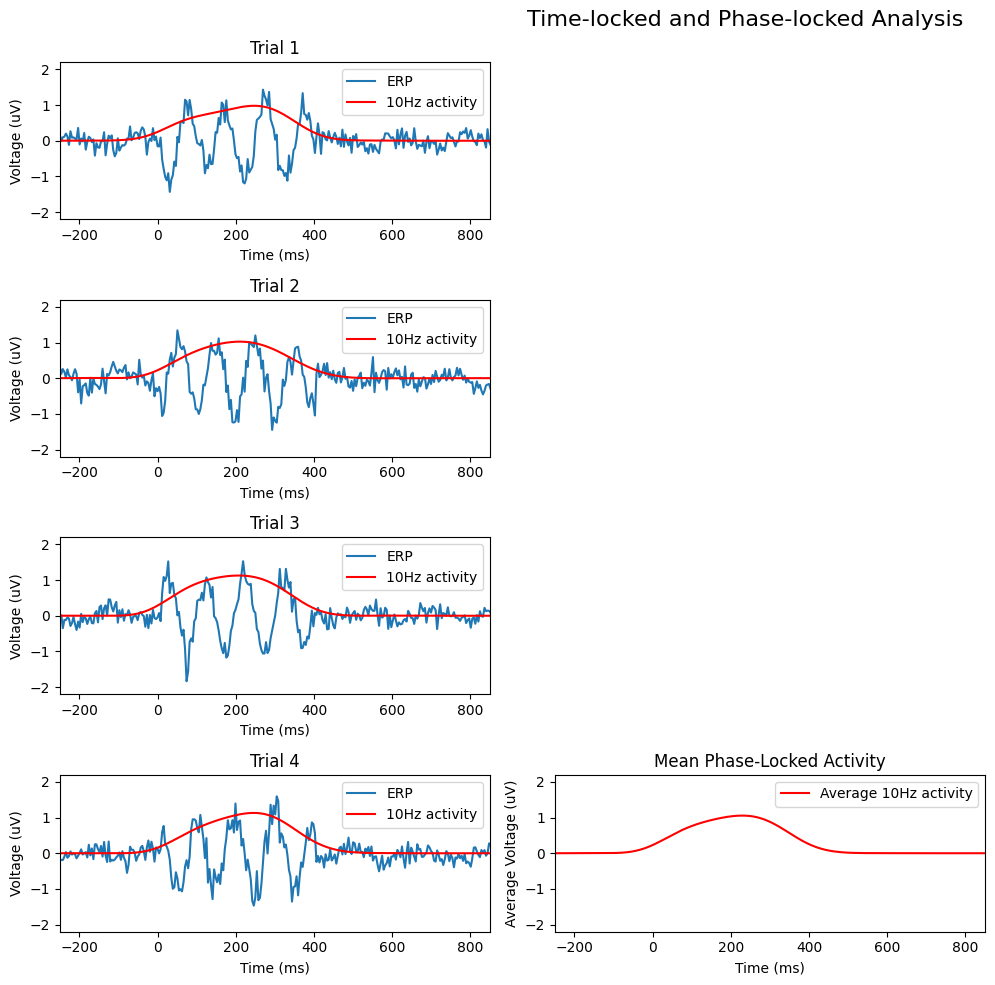

In [59]:

# Time-locked and phase-locked
plt.figure(figsize=(15, 10))
plt.suptitle('Time-locked and Phase-locked Analysis', fontsize=16)
for triali in range(nTrials):
    # Create single trial ERP
    data = 0.15 * np.sin(2 * np.pi * 6 * EEG['times'][0] / 1000 + 
                         2 * np.pi * triali / nTrials - np.pi) + np.random.randn(EEG['pnts'][0][0]) / 6
    # Add phase-locked stimulus potential
    data[259:360] = data[259:360] + np.sin(2 * np.pi * 10 * EEG['times'][0][259:360] / 1000) + np.random.randn(101) / 5
    
    # Convolve with 10Hz wavelet
    conv_res = fftconvolve(data, wavelet, 'same') * np.sqrt(5 / (2 * np.pi * 10))
    data10hz[triali, :] = 2 * np.abs(conv_res) ** 2
    
    # Plot single trials
    plt.subplot(nTrials, 3, triali * 3 + 1)
    plt.plot(EEG['times'][0], data, label='ERP')
    plt.plot(EEG['times'][0], data10hz[triali, :], 'r', label='10Hz activity')
    plt.xlim([-250, 850])
    plt.ylim([-2.2, 2.2])
    plt.title(f"Trial {triali+1}")
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (uV)')
    plt.legend()

# Plot the mean over trials
plt.subplot(nTrials, 3, nTrials * 3 - 1)
plt.plot(EEG['times'][0], np.mean(data10hz, axis=0), 'r', label='Average 10Hz activity')
plt.xlim([-250, 850])
plt.ylim([-2.2, 2.2])
plt.title('Mean Phase-Locked Activity')
plt.xlabel('Time (ms)')
plt.ylabel('Average Voltage (uV)')
plt.legend(loc='upper right')

plt.subplots_adjust(hspace=0.5)  # Add more space if necessary, depending on your figure
plt.tight_layout()
plt.show()


In [ ]:
# Non-time-locked and phase-locked
plt.figure(figsize=(15, 10))
plt.suptitle('Non-time-locked and Phase-locked Analysis', fontsize=16)
for triali in range(nTrials):
    # Create single trial ERP
    data = 0.15 * np.sin(2 * np.pi * 6 * EEG['times'][0] / 1000 + 
                         2 * np.pi * triali / nTrials - np.pi) + np.random.randn(EEG['pnts'][0][0]) / 6
    # Add phase-locked stimulus potential at random times
    eventtime = np.random.permutation(np.arange(80))[:1] + 240  # random permuted indices
    eventtime = np.arange(eventtime[0], eventtime[0]+81)  # plus one because Python indexing is exclusive at the end
    data[eventtime] = data[eventtime] + np.sin(2 * np.pi * 10 * EEG['times'][0][eventtime] / 1000 + 
                        2 * np.pi * triali / nTrials - np.pi) + np.random.randn(len(eventtime)) / 5
    
    # Convolve with 10Hz wavelet
    conv_res = fftconvolve(data, wavelet, 'same') * np.sqrt(5 / (2 * np.pi * 10))
    data10hz[triali, :] = 2 * np.abs(conv_res) ** 2
    
    # Plot single trials
    plt.subplot(nTrials, 3, triali * 3 + 1)
    plt.plot(EEG['times'][0], data, label='ERP')
    plt.plot(EEG['times'][0], data10hz[triali, :], 'r', label='10Hz activity')
    plt.xlim([-250, 850])
    plt.ylim([-2.2, 2.2])
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (uV)')
    plt.title(f'Trial {triali+1}')
    plt.legend()

# Plot the mean over trials
plt.subplot(nTrials, 3, nTrials * 3 - 1)
plt.plot(EEG['times'][0], np.mean(data10hz, axis=0), 'r', label='Avg 10Hz activity')
plt.xlim([-250, 850])
plt.ylim([-2.2, 2.2])
plt.title('Mean Phase-Locked at Random Times Activity')
plt.xlabel('Time (ms)')
plt.ylabel('Avg Voltage (uV)')
plt.legend(loc='upper right')

plt.subplots_adjust(hspace=0.5)  # Add more space if necessary, depending on your figure
plt.tight_layout()

plt.show()
